### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第51~53天作業(期中考)_V2
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/05/06
### 改版日期: 
### 2020/05/07 增加結果存檔
### 2020/05/08 調整離峰值處理
### 改版備註: 
### 參考網址
https://www.kaggle.com/tsilveira/machine-learning-tutorial-enron-e-mails

請至以下Kaggle競賽平台期中考連結參加考試，請按join competition加入測驗 

並將任一次提交完成畫面截圖，上傳到github並回到官網完成提交。(提交畫面截圖範例)

https://www.kaggle.com/t/4e455552ac9b4a088ccae16e27d22be8

### ANS:

## 目錄
* <a href="#sec1">1. 簡介</a>
  * <a href="#sec1.1"> 1.1. 匯入所需套件 </a>

* <a href="#sec2">2. 資料清洗</a>
  * <a href="#sec2.1"> 2.1. 匯入資料集 </a>
  * <a href="#sec2.2"> 2.2. 分析資料型態與分布 </a>
  * <a href="#sec2.3"> 2.3. 資料填補分析 </a>
  * <a href="#sec2.4"> 2.4. 缺失值填補 </a>
  * <a href="#sec2.5"> 2.5. 離峰值處理 </a>
  * <a href="#sec2.6"> 2.6. 異常值處理 </a>
  * <a href="#sec2.7"> 2.7. 資料檢查 </a>

* <a href="#sec3">3. 特徵工程</a>
  * <a href="#sec3.1"> 3.1. 特徵分析 </a>
  * <a href="#sec3.2"> 3.2. 特徵選擇 </a>
  * <a href="#sec3.3"> 3.3. 特徵縮放 </a>
  
* <a href="#sec4">4. 套用模型</a>
  * <a href="#sec4.1"> 4.1. Naive Bayes classifier </a>
  * <a href="#sec4.2"> 4.2. AdaBoost classifier </a> 
  * <a href="#sec4.3"> 4.3. SVM classifier </a>
  * <a href="#sec4.4"> 4.4. Conclusions </a>

<a id='sec1'></a>
### 1. 簡介
該項目是Udacity Data Analyst Nanodegree的一部分，涉及機器學習入門模塊。其主要範圍是根據因安然（Enron）醜聞而公開的財務和電子郵件數據來構建感興趣的人（POI）標識符，如下所述。
2000年，安然（Enron）是美國最大的公司之一。到2002年，由於廣泛的公司欺詐行為，該公司破產了。在最終的聯邦調查中，大量的通常是機密信息被輸入到公共記錄中，包括成千上萬的電子郵件和高級管理人員的詳細財務數據。

<a id='sec1.1'></a>
#### 1.1. 匯入套件及資料
本節為將在此python筆記本中使用的所有套件匯入

In [87]:
# 做完特徵工程前的所有準備 (與前範例相同)
import os
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm

### Importing Models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [88]:
## Importing "manually" some functions provided by Udacity and available at 
## https://github.com/tbnsilveira/DAND-MachineLearning/blob/master/tools/feature_format.py
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """
    return_list = []
    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )
    return np.array(return_list)

def targetFeatureSplit( data ):
    """ given a numpy array like the one returned from featureFormat, separate out the first feature and put it into its own list
    (this should be the quantity you want to predict) return targets and features as separate lists (sklearn can generally 
    handle both lists and numpy arrays as input formats when training/predicting) """
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )
    return target, features

<a id='sec2'></a>
### 2. 資料清洗

<a id='sec2.1'></a>
#### 2.1. 匯入資料集

In [89]:
data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
index_name = 'name'
df_train = df_train.set_index(df_train[index_name])
df_test = df_test.set_index(df_test[index_name])
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


<a id='sec2.2'></a>
#### 2.2. 分析資料型態與分布

In [90]:
# 重組資料成為訓練 / 預測用格式
target_col = 'poi'
key_col = 'name'
df_train[target_col] = df_train[target_col].map(lambda i: 1 if i == True else 0)
ids = df_test[key_col]
df_train = df_train.drop([key_col] , axis=1)
df_test = df_test.drop([key_col] , axis=1)
print(df_train.shape)
print(df_test.shape)

(113, 21)
(33, 20)


In [91]:
# 秀出資料欄位的類型與數量
dtype_df = df_train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,int64,1
1,float64,19
2,object,1


In [92]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於二個 list(數值及文字) 中
num_features = []
object_features = []
for dtype, feature in zip(df_train.dtypes, df_train.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)    
    else:
        object_features.append(feature)
# 將poi值移除
num_features.remove('poi')        
print(f'{len(num_features)} num Features : {num_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

19 num Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


In [93]:
def visualize3Feats(dataset, features):
    '''Shows the distribution and the boxplot for the given features of a pandas.Dataframe:
        dataset = pandas dataframe.
        features = list of features of interest'''
    ## Building the Figure:
    fig, axes = plt.subplots(2,3,figsize=(15,6), sharex=False)
    for col, feat in enumerate(features):
        dataset[feat].plot(kind='kde', ax=axes[0,col])
        sns.boxplot(x=dataset[feat], ax=axes[1,col])
        axes[0,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
        axes[1,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
    return

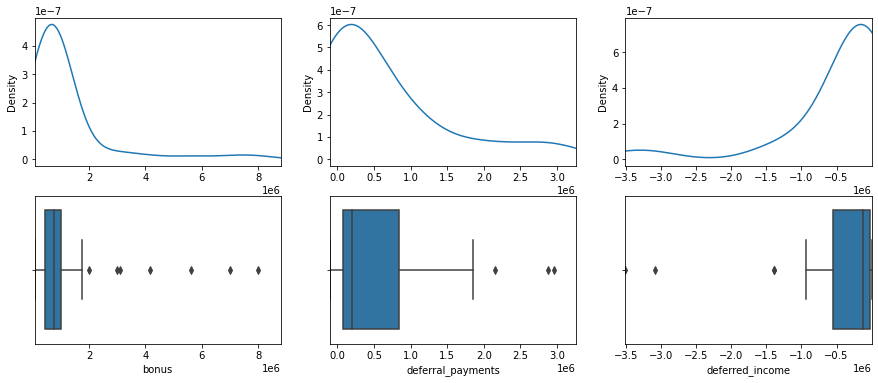

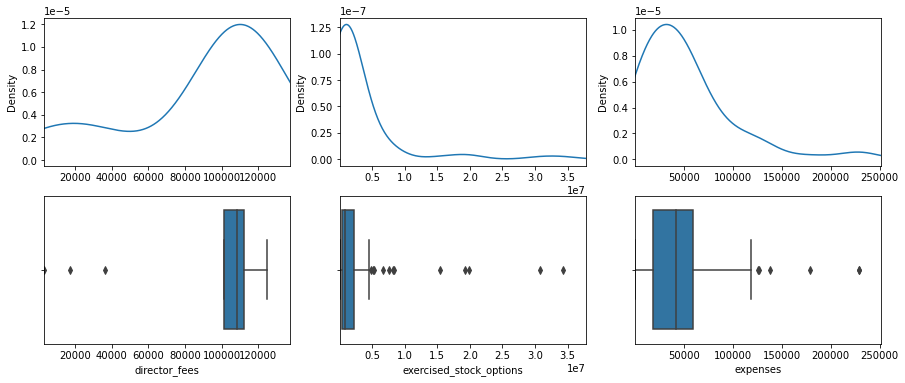

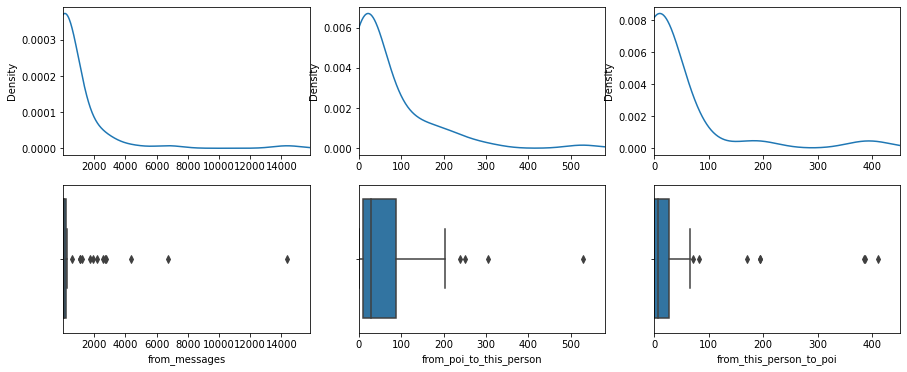

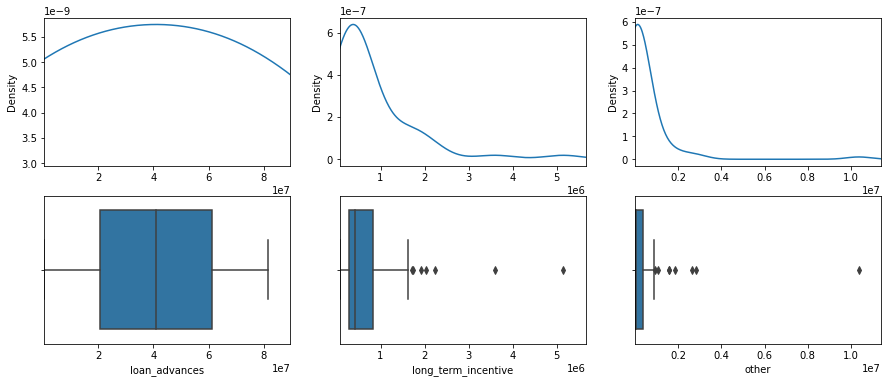

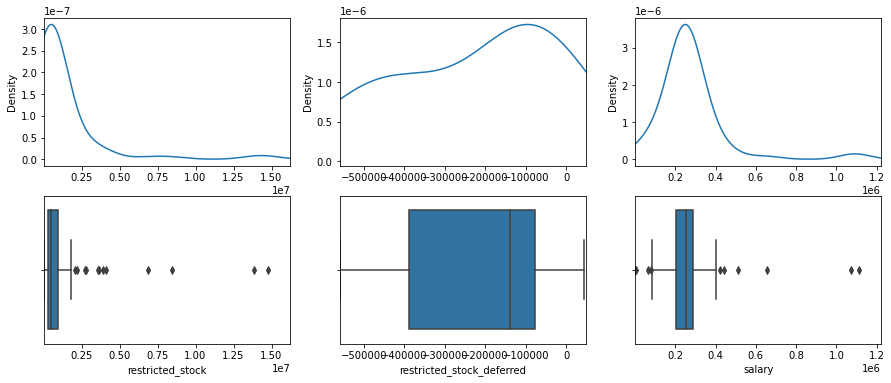

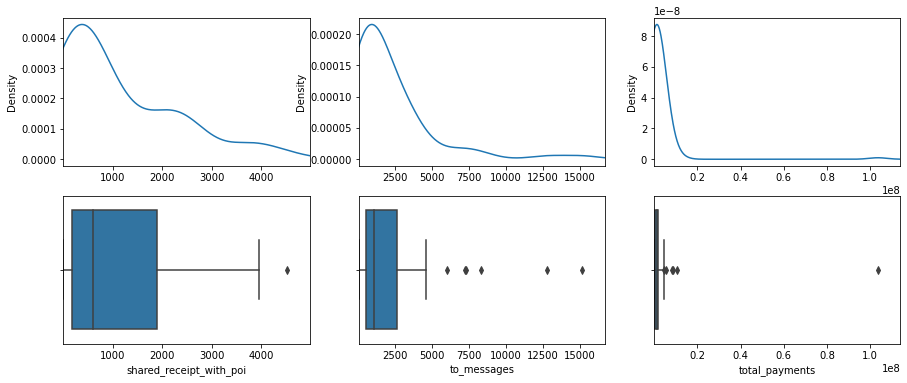

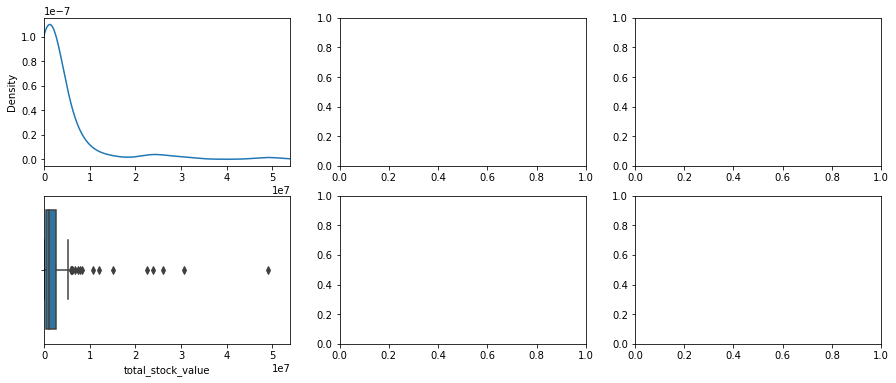

In [94]:
### 繪製KDE圖型及箱型圖:
numPlots = int(np.ceil(len(num_features)/3.))
for i in range(numPlots):
    shift = i*3
    visualize3Feats(df_train,num_features[0+shift:3+shift])

In [95]:
# 欄位值計算
print(df_train.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_train.select_dtypes(include=["int64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_train.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
# 欄位值計算

email_address    83
dtype: int64
----------------------
poi    2
dtype: int64
----------------------
loan_advances                 2
restricted_stock_deferred    10
director_fees                13
deferral_payments            28
deferred_income              30
from_this_person_to_poi      32
bonus                        33
long_term_incentive          40
from_poi_to_this_person      45
from_messages                51
shared_receipt_with_poi      64
to_messages                  65
other                        69
expenses                     72
restricted_stock             73
salary                       73
exercised_stock_options      80
total_payments               96
total_stock_value            96
dtype: int64


In [96]:
# 欄位值計算
print(df_test.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_test.select_dtypes(include=["int64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_test.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
# 欄位值計算

email_address    28
dtype: int64
----------------------
Series([], dtype: float64)
----------------------
loan_advances                 2
director_fees                 4
restricted_stock_deferred     8
deferral_payments            11
deferred_income              15
long_term_incentive          16
from_this_person_to_poi      16
bonus                        18
from_poi_to_this_person      18
from_messages                19
exercised_stock_options      21
salary                       21
shared_receipt_with_poi      21
to_messages                  21
expenses                     22
other                        24
restricted_stock             27
total_stock_value            28
total_payments               29
dtype: int64


In [97]:
## Only numerical features are being considered here
financialFeatures = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
                     'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive']
behavioralFeatures = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']
allFeatures = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']

<a id='sec2.3'></a>
#### 2.3. 資料填補分析

In [98]:
#檢查統計值
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,61.0,1.147436e+06,1.505189e+06,70000.0,450000.00,750000.0,1000000.00,8000000.0
deferral_payments,28.0,6.344374e+05,8.603646e+05,-102500.0,76567.50,195190.0,834205.25,2964506.0
deferred_income,34.0,-4.625664e+05,8.095392e+05,-3504386.0,-552703.25,-117534.0,-27083.25,-1042.0
director_fees,13.0,8.939785e+04,4.114339e+04,3285.0,101250.00,108579.0,112492.00,125034.0
exercised_stock_options,81.0,2.985081e+06,6.004174e+06,3285.0,400478.00,850010.0,2165172.00,34348384.0
expenses,73.0,5.104055e+04,4.759668e+04,148.0,18834.00,41953.0,59175.00,228763.0
from_messages,65.0,7.113231e+02,2.074498e+03,12.0,19.00,45.0,215.00,14368.0
from_poi_to_this_person,65.0,6.480000e+01,9.186321e+01,0.0,10.00,28.0,88.00,528.0
from_this_person_to_poi,65.0,4.009231e+01,8.890141e+01,0.0,0.00,7.0,27.00,411.0
loan_advances,2.0,4.096250e+07,5.736404e+07,400000.0,20681250.00,40962500.0,61243750.00,81525000.0


In [99]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,21.0,5.937791e+06,2.097902e+07,100000.0,425000.00,1000000.0,2000000.00,97343619.0
deferral_payments,11.0,4.209095e+06,9.442610e+06,51365.0,232265.00,564348.0,2637936.50,32083396.0
deferred_income,15.0,-2.677068e+06,7.096873e+06,-27992891.0,-1809217.00,-235000.0,-129288.00,-833.0
director_fees,4.0,4.183778e+05,6.547074e+05,38346.0,83674.50,118324.0,453027.25,1398517.0
exercised_stock_options,21.0,1.756609e+07,6.746116e+07,765920.0,1030329.00,2027865.0,4160672.00,311764000.0
expenses,22.0,3.001494e+05,1.102936e+06,2151.0,34283.75,61817.0,96182.00,5235198.0
from_messages,21.0,2.914286e+02,7.026554e+02,12.0,25.00,29.0,75.00,3069.0
from_poi_to_this_person,21.0,6.519048e+01,7.175278e+01,0.0,28.00,40.0,64.00,242.0
from_this_person_to_poi,21.0,4.476190e+01,1.313537e+02,0.0,1.00,12.0,21.00,609.0
loan_advances,2.0,4.296250e+07,5.792972e+07,2000000.0,22481250.00,42962500.0,63443750.00,83925000.0


In [100]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)

In [101]:
na_check(df_train)
na_check(df_test)

,Missing Ratio
loan_advances,98.230088
restricted_stock_deferred,91.150442
director_fees,88.495575
deferral_payments,75.221239
deferred_income,69.911504
long_term_incentive,56.637168
bonus,46.017699
from_messages,42.477876
from_poi_to_this_person,42.477876
from_this_person_to_poi,42.477876


,Missing Ratio
loan_advances,93.939394
director_fees,87.878788
restricted_stock_deferred,75.757576
deferral_payments,66.666667
deferred_income,54.545455
long_term_incentive,48.484848
from_this_person_to_poi,36.363636
from_poi_to_this_person,36.363636
exercised_stock_options,36.363636
from_messages,36.363636


<a id='sec2.4'></a>
#### 2.4. 缺失值填補

In [102]:
# 付款資料
payment_data = ['salary','bonus','long_term_incentive','deferred_income','deferral_payments','loan_advances','other'\
               ,'expenses','director_fees','total_payments']
# 股票資產資料
stock_data = ['exercised_stock_options','restricted_stock','restricted_stock_deferred',\
             'total_stock_value']
# 郵件次數資料
email_data=['from_this_person_to_poi','from_poi_to_this_person','to_messages',\
            'shared_receipt_with_poi','to_messages','from_messages']


# 缺失值補0(email次數,付款資料,股票資產資料)
df_train[num_features] = df_train[num_features].fillna(0)
df_test[num_features] = df_test[num_features].fillna(0)

In [103]:
#顯示訓練集其中資料遺失比例(只剩email_address)
na_check(df_train)
na_check(df_test)

,Missing Ratio
email_address,26.548673


,Missing Ratio
email_address,15.151515


<a id='sec2.5'></a>
#### 2.5. 離峰值處理

df_train outlier
0    112
1      1
Name: outlier, dtype: int64
df_test outlier
0    32
1     1
Name: outlier, dtype: int64


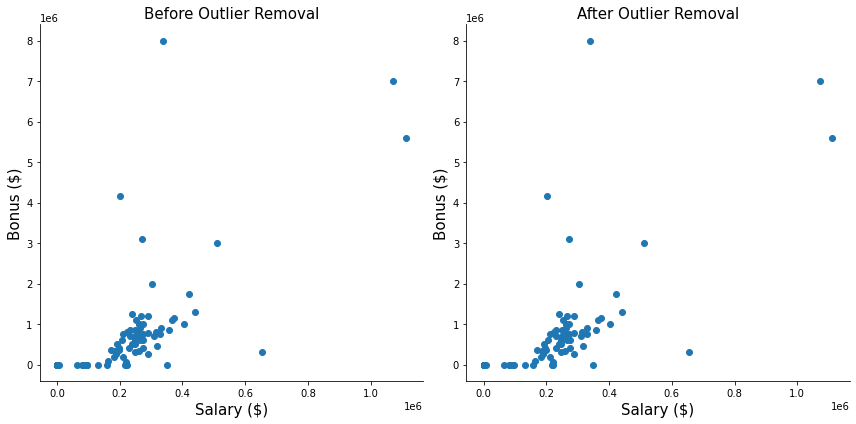

In [104]:
# TOTAL 及 THE TRAVEL AGENCY IN THE PARK 是合計欄(非個人資料)，要刪除
### Visualizing Salary v/s Balance Graphs for outlier identification
figure, (axes1, axes2) = plt.subplots(ncols=2, figsize=(12, 6))

axes1.scatter(df_train.salary, df_train.bonus)
axes1.set_xlabel("Salary ($)", fontsize=15)
axes1.set_ylabel("Bonus ($)", fontsize=15)
axes1.set_title("Before Outlier Removal", fontsize=15)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)

# print('index[total]:{0}'.format(str(len(df_train[df_train.index == 'TOTAL']))))
# print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(df_train[df_train.index\
# == 'THE TRAVEL AGENCY IN THE PARK']))))
# # Dropping the outliers
# outlier_set = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
# for outle in outlier_set:
#     if outle in df_train.index:
#         df_train.drop([outle], axis = 0, inplace=True)        
# print('index[total]:{0}'.format(str(len(df_train[df_train.index == 'TOTAL']))))
# print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(df_train[df_train.index\
# == 'THE TRAVEL AGENCY IN THE PARK']))))
# print(df_train.shape)

# 離峰值增加欄位住記
df_train['outlier']= 0
df_test['outlier']= 0
outlier_set = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
for indexs in outlier_set:
    if indexs in df_train.index:
        df_train.loc[indexs,'outlier'] = 1
    if indexs in df_test.index:
        df_test.loc[indexs,'outlier'] = 1

print('df_train outlier')
print(df_train['outlier'].value_counts())
print('df_test outlier')
print(df_test['outlier'].value_counts())

axes2.scatter(df_train.salary, df_train.bonus)
axes2.set_xlabel("Salary ($)", fontsize=15)
axes2.set_ylabel("Bonus ($)", fontsize=15)
axes2.set_title("After Outlier Removal", fontsize=15)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

figure.tight_layout()
plt.show()


<a id='sec2.6'></a>
#### 2.6. 異常值處理

In [105]:
#驗證資料內容前先複製一份
dt_eval = pd.concat([df_train,df_test])

In [106]:
# 計算付款資料合理性
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
print(errors.shape)
errors

(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,outlier,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0


In [107]:
# 計算股票資產資料合理性
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
print(errors.shape)
errors

(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,outlier,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0


In [108]:
# 查看有問題的兩筆資料，發現資料位移
# 處理訓練集
# Check for any more errors with the payment data
print(len(df_train[df_train[payment_data[:-1]].sum(axis='columns') !=df_train['total_payments']]))
# Check for any errors with the stock data
print(len(df_train[df_train[stock_data[:-1]].sum(axis='columns') !=df_train['total_stock_value']]))

payment_len = df_train[payment_data[:-1]].shape[1]
stock_len = df_train[stock_data[:-1]].shape[1]

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
key_name in df_train.index
if key_name in df_train.index:
    print('find {0} !'.format(str(key_name)))
    for i in range(payment_len):
        df_train.loc[key_name,payment_data[i]] = df_train.loc[key_name,payment_data[i+1]]
    df_train.loc[key_name,payment_data[payment_len]] = df_train.loc[key_name,stock_data[0]]

    for i in range(stock_len):
        df_train.loc[key_name,stock_data[i]] = float(df_train.loc[key_name,stock_data[i+1]])
    df_train.loc[key_name,stock_data[stock_len]] = 0


# 'BHATNAGAR SANJAY' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'
if key_name in df_train.index:
    print('find {0} !'.format(str(key_name)))
    for i in np.arange(1,stock_len+1)[::-1]:
        df_train.loc[key_name,stock_data[i]] = float(df_train.loc[key_name,stock_data[i-1]])
    df_train.loc[key_name,stock_data[0]] = df_train.loc[key_name,payment_data[payment_len]]

    for i in np.arange(1,payment_len+1)[::-1]:
        df_train.loc[key_name,payment_data[i]] = df_train.loc[key_name,payment_data[i-1]]
    df_train.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(df_train[df_train[payment_data[:-1]].sum(axis='columns') !=df_train['total_payments']]))
# Check for any errors with the stock data
print(len(df_train[df_train[stock_data[:-1]].sum(axis='columns') !=df_train['total_stock_value']]))

1
1
find BELFER ROBERT !
0
0


In [109]:
# 查看有問題的兩筆資料，發現資料位移
# 處理測試集
# Check for any more errors with the payment data
print(len(df_test[df_test[payment_data[:-1]].sum(axis='columns') !=df_test['total_payments']]))
# Check for any errors with the stock data
print(len(df_test[df_test[stock_data[:-1]].sum(axis='columns') !=df_test['total_stock_value']]))

payment_len = df_test[payment_data[:-1]].shape[1]
stock_len = df_test[stock_data[:-1]].shape[1]

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
key_name in df_test.index
if key_name in df_test.index:
    print('find {0} !'.format(str(key_name)))
    for i in range(payment_len):
        df_test.loc[key_name,payment_data[i]] = df_test.loc[key_name,payment_data[i+1]]
    df_test.loc[key_name,payment_data[payment_len]] = df_test.loc[key_name,stock_data[0]]

    for i in range(stock_len):
        df_test.loc[key_name,stock_data[i]] = float(df_test.loc[key_name,stock_data[i+1]])
    df_test.loc[key_name,stock_data[stock_len]] = 0


# 'BHATNAGAR SANJAY' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'
if key_name in df_test.index:
    print('find {0} !'.format(str(key_name)))
    for i in np.arange(1,stock_len+1)[::-1]:
        df_test.loc[key_name,stock_data[i]] = float(df_test.loc[key_name,stock_data[i-1]])
    df_test.loc[key_name,stock_data[0]] = df_test.loc[key_name,payment_data[payment_len]]

    for i in np.arange(1,payment_len+1)[::-1]:
        df_test.loc[key_name,payment_data[i]] = df_test.loc[key_name,payment_data[i-1]]
    df_test.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(df_test[df_test[payment_data[:-1]].sum(axis='columns') !=df_test['total_payments']]))
# Check for any errors with the stock data
print(len(df_test[df_test[stock_data[:-1]].sum(axis='columns') !=df_test['total_stock_value']]))

1
1
find BHATNAGAR SANJAY !
0
0


In [110]:
# 檢查次數項目是否為正整數(大於等於0)
for col_name in email_data:    
    if all(dt_eval[col_name].dropna().unique()>=0):
        print('column [{0}] pass!'.format(col_name))        
    else:
        print('column [{0}] fail!'.format(col_name))
        print(dt_eval[col_name].dropna().unique())

column [from_this_person_to_poi] pass!
column [from_poi_to_this_person] pass!
column [to_messages] pass!
column [shared_receipt_with_poi] pass!
column [to_messages] pass!
column [from_messages] pass!


<a id='sec2.7'></a>
#### 2.7. 資料檢查

In [111]:
#顯示訓練集與測試集其中資料遺失比例(只剩email_address)
na_check(df_train)
na_check(df_test)

,Missing Ratio
email_address,26.548673


,Missing Ratio
email_address,15.151515


<a id='sec3'></a>
### 3.特徵工程
**Note:** the initial approach was to split the dataset and to build out new features from the test data. However, since the 'poi_id.py' suggested by Udacity splits the data only after the feature engineering, we will then use the original dataset, splitting it up only before machine learning training.

<a id='sec3.1'></a>
#### 3.1. 特徵分析
Considering feature extraction, high correlated variables usually are useless for machine learning classification. In this case, it's better to use uncorrelated variables as features, in the way they are orthogonal to each other and so brings on different information aspects from data.  

To check which features are correlated or not we will then use a method from pandas library (http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.corr.html) and show it through a heatmap to make easier the visualization, as follow:

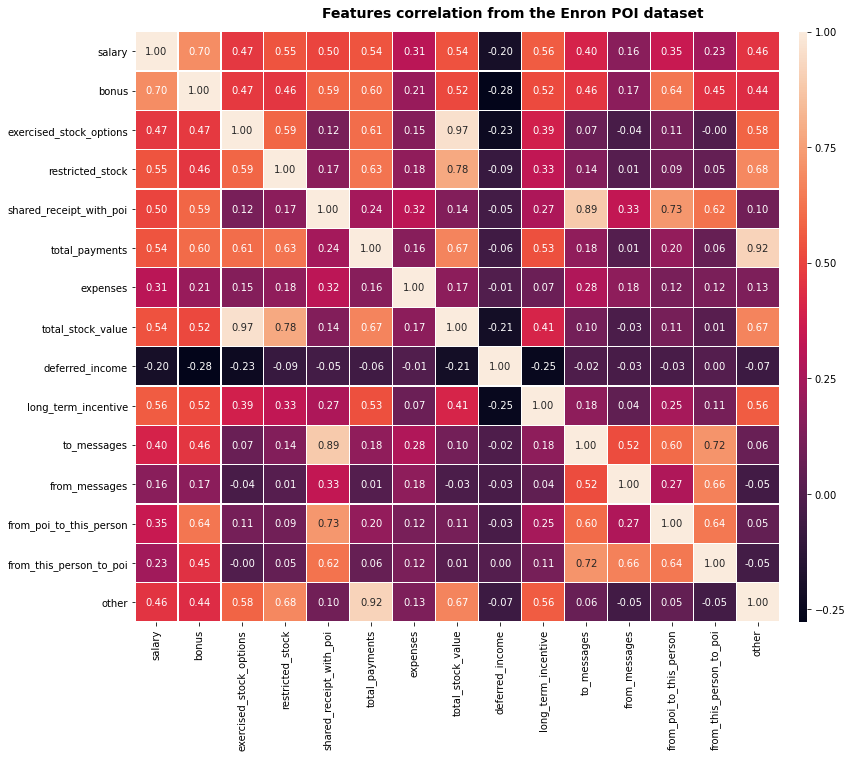

In [112]:
#繪製熱點圖
## Calculating the correlation among features by Pearson method
correlationDataframe = df_train[allFeatures].corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws);

<a id='sec3.2'></a>
#### 3.2. 特徵選擇
Since the financial features are highly correlated, as seen above, we will now apply PCA to generate an only one new feature from them. 

In [113]:
from sklearn.decomposition import PCA

In [114]:
## Listing the financial features
financialFeatures

['salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive']

In [115]:
## Defining only one resulting component:
pca = PCA(n_components=1)
pca.fit(df_train[financialFeatures])

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

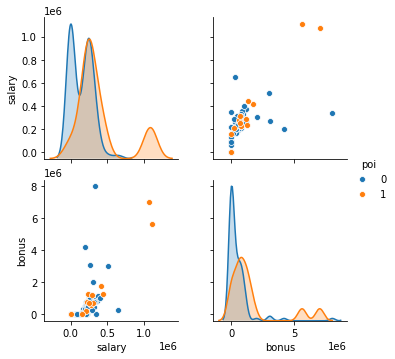

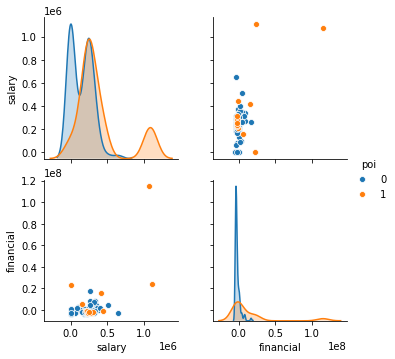

In [116]:
pcaComponents = pca.fit_transform(df_train[financialFeatures])
df_train['financial'] = pcaComponents
sns.pairplot(df_train,hue='poi',vars=['salary','bonus'], diag_kind='kde');
sns.pairplot(df_train,hue='poi',vars=['salary','financial'], diag_kind='kde');

In [117]:
pcaComponents = pca.fit_transform(df_test[financialFeatures])
df_test['financial'] = pcaComponents

In [118]:
## Adding up the new 'financial' feature to the 'allFeatures' list:
allFeatures.append('financial')
financialFeatures.append('financial')
allFeatures.append('outlier')
financialFeatures.append('outlier')

In [119]:
allFeatures

['salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'other',
 'financial',
 'outlier']

The code below is based on the example available in http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py, in which an univariate feature selection is applied. 

In [120]:
from sklearn.feature_selection import SelectPercentile, f_classif

selectorDataset = df_train[financialFeatures]
selectorLabel = df_train['poi']

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 5% most significant features
selector = SelectPercentile(f_classif, percentile=5)
selector.fit(selectorDataset, selectorLabel)

SelectPercentile(percentile=5,
                 score_func=<function f_classif at 0x000000000D4A3708>)

<BarContainer object of 12 artists>

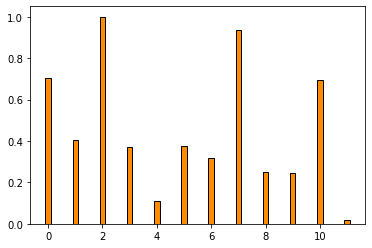

In [121]:
## Plotting the features selection: 
X_indices = np.arange(selectorDataset.shape[-1])
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [122]:
len(scores)

12

In [123]:
## Printing out the selected financial features: 
selectedFeatures = []  #'poi' must be the first one due to the evaluation methods defined by Udacity.
for ix, pval in enumerate(scores):
    print(financialFeatures[ix],': ',pval)
    if (pval >= 0.45):
        selectedFeatures.append(financialFeatures[ix])

salary :  0.7023228093091374
bonus :  0.4037437978084236
exercised_stock_options :  1.0
restricted_stock :  0.3731972499945856
shared_receipt_with_poi :  0.11078453107585005
total_payments :  0.377324720020806
expenses :  0.31801380695678655
total_stock_value :  0.9346874215457623
deferred_income :  0.2519893798095256
long_term_incentive :  0.24491760886073027
financial :  0.6926552173613756
outlier :  0.020714147793199734


In [124]:
selectedFeatures

['salary', 'exercised_stock_options', 'total_stock_value', 'financial']

##### Alternative feature selection
Since the PCA applied to the financial features creates a new variable ('financial') which contains the most important components of the others, one alternative is to append it to the behavioral features selected before, in what we call *strategicFeatures*. In the next sections we will evaluate the performance of applying machine learning in this two classes of features.

In [125]:
strategicFeatures = behavioralFeatures + ['financial']

In [126]:
strategicFeatures

['to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'other',
 'financial']

<a id='sec3.3'></a>
#### 3.3. 特徵縮放
Besides some of the machine learning algorithms chosen for this analysis (Naive Bayes and Adaboost) are invariant to feature scaling (Ref: https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm), since we are also interested in using SVM it is important to apply feature scaling in our dataset. Furthermore, the "strategicFeatures" mixes two types of data, the financial data from PCA and the behavioral data from the number of emails sent.

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train[allFeatures])
df_train[allFeatures] = scaler.transform(df_train[allFeatures])
df_test[allFeatures] = scaler.transform(df_test[allFeatures])

In [128]:
## Converting back the pandas Dataframe to the dictionary structure, in order to use the Udacity evaluating code.
my_dataset = df_train.to_dict(orient='index')
features_list = ['poi'] + selectedFeatures
#features_list = strategicFeatures

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
test_X = df_test[selectedFeatures].values.tolist()
print(len(my_dataset))

113


<a id='sec4'></a>
### 4. 套用模型

#### Pick up an Algorithm(選擇模型)

Different algorithms were attempted using the above mentioned feature list.
I tried **Decision Tree Classifier**, **Random Forest Classifier**, **Ada Boost Classifier**, **Gaussian Naive Bayes**, **K-Nearest Neighbors**

In [129]:
# Splitting up the data
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [130]:
## Defining an evaluation metric based on (http://scikit-learn.org/stable/modules/model_evaluation.html)
from sklearn.metrics import classification_report
def evaluateClassif(clf):
    classes=['Non-POI','POI']  ## Defining the classes labels
    predTrain = clf.predict(features_train)
    print('################### Training data ##################')
    print(classification_report(labels_train, predTrain, target_names=classes))
    
    predTest = clf.predict(features_test)
    print('################### Testing data ###################')
    print(classification_report(labels_test, predTest, target_names=classes))
    
    return

<a id='sec4.1'></a>
#### 4.1. Naive Bayes classifier

In [131]:
nb = GaussianNB()
nb_parameters = {}

In [132]:
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [133]:
evaluateClassif(clf_nb)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       0.94      0.96      0.95        70
         POI       0.57      0.50      0.53         8

    accuracy                           0.91        78
   macro avg       0.76      0.73      0.74        78
weighted avg       0.91      0.91      0.91        78

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.88      0.97      0.92        29
         POI       0.50      0.20      0.29         5

    accuracy                           0.85        34
   macro avg       0.69      0.58      0.60        34
weighted avg       0.82      0.85      0.83        34



In [134]:
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(features, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [135]:
# 儲存預測結果(樸素貝葉斯分類器)
output_path = 'output/'
predicitons1 = clf_nb.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': predicitons1})
f_app_result = os.path.join(output_path, 'Day_051_To_053_V2_nbc.csv')
submit.to_csv(f_app_result,index=False)

<a id='sec4.2'></a>
#### 4.2. AdaBoost classifier

### http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py

In [136]:
## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)

In [137]:
clf_adaboost.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf

In [138]:
evaluateClassif(clf_adaboost)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       1.00      1.00      1.00        70
         POI       1.00      1.00      1.00         8

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.88      0.97      0.92        29
         POI       0.50      0.20      0.29         5

    accuracy                           0.85        34
   macro avg       0.69      0.58      0.60        34
weighted avg       0.82      0.85      0.83        34



In [139]:
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)
clf_adaboost.fit(features, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf

In [140]:
# 儲存預測結果(AdaBoost classifier)
output_path = 'output/'
predicitons1 = clf_adaboost.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': predicitons1})
f_app_result = os.path.join(output_path, 'Day_051_To_053_V2_abc.csv')
submit.to_csv(f_app_result,index=False)

<a id='sec4.3'></a>
#### 4.3. SVM classifier

In [141]:
svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 
                  'C':[0.5,1.,5.,10.,50.,100.,1000.], 'gamma':['scale']}
svr = svm.SVC()

In [142]:
clf_svc = GridSearchCV(svr, svm_parameters);

In [143]:
clf_svc.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0],
                         'gamma': ['scale'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [144]:
evaluateClassif(clf_svc)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       0.93      1.00      0.97        70
         POI       1.00      0.38      0.55         8

    accuracy                           0.94        78
   macro avg       0.97      0.69      0.76        78
weighted avg       0.94      0.94      0.92        78

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.88      0.97      0.92        29
         POI       0.50      0.20      0.29         5

    accuracy                           0.85        34
   macro avg       0.69      0.58      0.60        34
weighted avg       0.82      0.85      0.83        34



In [145]:
svr = svm.SVC(probability=True)
clf_svc = GridSearchCV(svr, svm_parameters)
clf_svc.fit(features, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0],
                         'gamma': ['scale'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [146]:
# 儲存預測結果(svm)
output_path = 'output/'
predicitons1 = clf_svc.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': predicitons1})
f_app_result = os.path.join(output_path, 'Day_051_To_053_V2_svm.csv')
submit.to_csv(f_app_result,index=False)

<a id='sec4.4'></a>
####  4.4. Conclusions
Evaluating the output of the classifiers above, it's effort to choose **Naive Bayes Classifier**, since it had the best considered metrics (precision and recall) for POI in the testing data. It must be considered, though, that we could use more strategies to iterate the test and to certify this would be the best machine learning algorithm to be used. 